# Working with Continuous Data

We have previously done some work with continuous data when we were learning about visualizations. In this section we are going to look at some methods that will help you examine associations between continuous variables. The primary tool we are going to use is the correlation. 

In this section, we will use a new library for visualizations, called `seaborn`. Seaborn is traditionally imported with the abbreviation `sns`

The specific methods we will use that we haven't covered before are:

* `corr()`, a dataframe method from pandas
* `heatmap()`, a plotting method from seaborn
* `pairplot()`, a plotting method from seaborn
* `unique()` a series method from pandas



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# For slightly nicer charts
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 150
sns.set(style="ticks")

***

## Preparing our Dataset

For this section we will use a selection from the dataset `fandango_score_comparison.csv` ([source](https://github.com/fivethirtyeight/data/tree/master/fandango)), containing data about movie ratings from Fandango, Rotten Tomatoes, IMDB, and Metacritic. The dataset was used for this article, [Be Suspicious Of Online Movie Ratings, Especially Fandango’s](https://fivethirtyeight.com/features/fandango-movies-ratings/), published by [fivethirtyeight](https://fivethirtyeight.com/).

First, we read a CSV file of the movie ratings and assign it to a variable called `df_full`. We will then select a subset of the data and assign the subsection to the variable `df`.
Each row in the dataset represents one movie.  The columns are labelled as follows: 

* FILM: The film in question
* RottenTomatoes: The Rotten Tomatoes Tomatometer score for the film
* RottenTomatoes_User: The Rotten Tomatoes user score for the film
* Metacritic: The Metacritic critic score for the film
* Metacritic_User: The Metacritic user score for the film
* IMDB: The IMDb user score for the film
* Fandango_Stars: The number of stars the film had on its Fandango movie page
* Fandango_Ratingvalue: The Fandango ratingValue for the film, as pulled from the HTML of each page. This is the actual average score the movie obtained.



In [3]:
df_full = pd.read_csv("fandango_score_comparison.csv")
df = df_full.loc[:,'FILM':'Fandango_Ratingvalue'] # this creates a subset of the dataframe using location based indexing, which we will discuss later 
df.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 8 columns):
FILM                    146 non-null object
RottenTomatoes          146 non-null int64
RottenTomatoes_User     146 non-null int64
Metacritic              146 non-null int64
Metacritic_User         146 non-null float64
IMDB                    146 non-null float64
Fandango_Stars          146 non-null float64
Fandango_Ratingvalue    146 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 9.2+ KB


Our dataset has 146 movies (one per row) and eight columns. The first column labelled `'FILM'` contains strings with the name of the Film and its year of release. The remaining columns are either integers or floats representing various kinds of ratings of the quality of the film.

***

Before we start looking at how the ratings are related to one another, let's look at some descriptive statistics.

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RottenTomatoes,146.0,60.849315,30.168799,5.0,31.25,63.50,89.0,100.0
RottenTomatoes_User,146.0,63.876712,20.024430,20.0,50.00,66.50,81.0,94.0
Metacritic,146.0,58.808219,19.517389,13.0,43.50,59.00,75.0,94.0
Metacritic_User,146.0,6.519178,1.510712,2.4,5.70,6.85,7.5,9.6
IMDB,146.0,6.736986,0.958736,4.0,6.30,6.90,7.4,8.6
Fandango_Stars,146.0,4.089041,0.540386,3.0,3.50,4.00,4.5,5.0
Fandango_Ratingvalue,146.0,3.845205,0.502831,2.7,3.50,3.90,4.2,4.8


Notice, the variations in the mean, min, and max values across the different ratings sites. Some of the ratings systems appear to be using 100 points scales, others 10 points scales, and others 5 points scales. Also, no matter what the scale, the average rating tends to be just a bit higher than the mid-point of the scale. 

The different scales make looking at the descriptive statistics a bit confusing so let's convert all the scales to be the same. This conversion process is commonly called 'normalizing' your data. In this case we are going to convert everything to a 10-point scale. 

We are NOT going to 'copy over' the existing values. Instead we are going to calculate new values and assign them to new columns.  

First, we will normalize the 100-point columns and assign them to new columns. 

In [6]:
hundred_list = ['RottenTomatoes', 'RottenTomatoes_User', 'Metacritic']
df[['RottenTomatoes_Norm', 'RottenTomatoes_User_Norm', 'Metacritic_Norm']] = df[hundred_list]/10
df.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RottenTomatoes_Norm,RottenTomatoes_User_Norm,Metacritic_Norm
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,7.4,8.6,6.6
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,8.5,8.0,6.7
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,8.0,9.0,6.4
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,1.8,8.4,2.2
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,1.4,2.8,2.9


Second, we will normalize the 5-point columns and assign them to new columns. 

In [7]:
five_list = ['Fandango_Stars', 'Fandango_Ratingvalue']
df[['Fandango_Stars_Norm', 'Fandango_Ratingvalue_Norm']] = df[five_list]*2
df.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RottenTomatoes_Norm,RottenTomatoes_User_Norm,Metacritic_Norm,Fandango_Stars_Norm,Fandango_Ratingvalue_Norm
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,7.4,8.6,6.6,10.0,9.0
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,8.5,8.0,6.7,10.0,9.0
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,8.0,9.0,6.4,10.0,9.0
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,1.8,8.4,2.2,10.0,9.0
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,1.4,2.8,2.9,7.0,6.0


Now we are going to drop all of the non-normed columns.

In [8]:
non_normed_ratings_list = ['RottenTomatoes', 'RottenTomatoes_User', 'Metacritic', 'Fandango_Stars', 'Fandango_Ratingvalue']
df = df.drop(columns=non_normed_ratings_list)
df.head()

,FILM,Metacritic_User,IMDB,RottenTomatoes_Norm,RottenTomatoes_User_Norm,Metacritic_Norm,Fandango_Stars_Norm,Fandango_Ratingvalue_Norm
0,Avengers: Age of Ultron (2015),7.1,7.8,7.4,8.6,6.6,10.0,9.0
1,Cinderella (2015),7.5,7.1,8.5,8.0,6.7,10.0,9.0
2,Ant-Man (2015),8.1,7.8,8.0,9.0,6.4,10.0,9.0
3,Do You Believe? (2015),4.7,5.4,1.8,8.4,2.2,10.0,9.0
4,Hot Tub Time Machine 2 (2015),3.4,5.1,1.4,2.8,2.9,7.0,6.0


## A Small Aside About Reusable Code

So our output above looks great but our column order is bit jumbled. Let's do a quick fix to get the ratings in alphabetical order. We are going to need a list with the labels in the proper order first. We can make a list manually:

In [9]:
label_order_list_manual = ['FILM', 'Fandango_Ratingvalue_Norm', 'Fandango_Stars_Norm', 'IMDB', 'Metacritic_Norm', 'Metacritic_User', 'RottenTomatoes_Norm', 'RottenTomatoes_User_Norm']

Or we can make a list using a few properties and methods.

In [10]:
label_order_list_fancy = df.columns.tolist()
label_order_list_fancy.sort() #Note that the sort() method sorts the list 'in place' and does not return anything, therefore it cannot be assigned to a variable

Both methods produce the same results.

In [11]:
print('Manual result:', label_order_list_manual)
print('Fancy  result:', label_order_list_fancy)

Manual result: ['FILM', 'Fandango_Ratingvalue_Norm', 'Fandango_Stars_Norm', 'IMDB', 'Metacritic_Norm', 'Metacritic_User', 'RottenTomatoes_Norm', 'RottenTomatoes_User_Norm']
Fancy  result: ['FILM', 'Fandango_Ratingvalue_Norm', 'Fandango_Stars_Norm', 'IMDB', 'Metacritic_Norm', 'Metacritic_User', 'RottenTomatoes_Norm', 'RottenTomatoes_User_Norm']


For small datasets, manually creating lists may make sense and may be an efficient use of your time. However, it will often be the case that writing code to automate these types of processes will save you time and make your process less error prone. This will be particularly true for large datasets. Another advatage of solving your problems with code is the code can often be reused. The code for the 'fancy' approach above could be used with any dataset, while the manually created list will likely only ever be useful this one specific time. 

So we now have our list (we can use either), let's use it to 'reorder' our dataframe.

In [12]:
df = df[label_order_list_fancy]
df.head()

,FILM,Fandango_Ratingvalue_Norm,Fandango_Stars_Norm,IMDB,Metacritic_Norm,Metacritic_User,RottenTomatoes_Norm,RottenTomatoes_User_Norm
0,Avengers: Age of Ultron (2015),9.0,10.0,7.8,6.6,7.1,7.4,8.6
1,Cinderella (2015),9.0,10.0,7.1,6.7,7.5,8.5,8.0
2,Ant-Man (2015),9.0,10.0,7.8,6.4,8.1,8.0,9.0
3,Do You Believe? (2015),9.0,10.0,5.4,2.2,4.7,1.8,8.4
4,Hot Tub Time Machine 2 (2015),6.0,7.0,5.1,2.9,3.4,1.4,2.8


That looks pretty good. Let's rerun our descriptives and take another look at the variables.

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Fandango_Ratingvalue_Norm,146.0,7.690411,1.005662,5.4,7.000,7.80,8.4,9.6
Fandango_Stars_Norm,146.0,8.178082,1.080772,6.0,7.000,8.00,9.0,10.0
IMDB,146.0,6.736986,0.958736,4.0,6.300,6.90,7.4,8.6
Metacritic_Norm,146.0,5.880822,1.951739,1.3,4.350,5.90,7.5,9.4
Metacritic_User,146.0,6.519178,1.510712,2.4,5.700,6.85,7.5,9.6
RottenTomatoes_Norm,146.0,6.084932,3.016880,0.5,3.125,6.35,8.9,10.0
RottenTomatoes_User_Norm,146.0,6.387671,2.002443,2.0,5.000,6.65,8.1,9.4


Now that we have 'normed' the data the difference in mean ratings across the rating sites really stands out. (For more about this issue see [the original article](https://fivethirtyeight.com/features/fandango-movies-ratings/)). However, what we are interested in right now is the degree to which the various ratings are associated (or how much they covary). 
***

## Looking at Associations Using Correlations
We often want to know the degree to which one variable is associated with another. We don't always say 'associated' when asking these types of questions; instead, we will often use the word 'predict'. For example, we might say we want to know if the price of milk will 'predict' the price of cheese. Unfortunately, the word 'predict' (or the phrase 'this predicts that') often implies things we (or our data) are not prepared to address. So it's a bit more cautious to talk about whether or not the price of milk is 'associated' with the price of cheese.

If you are interested in how two variable are associated there are a bunch of formal statistical tests you might use to characterize the association. The type of test you would use depends on the type of data you are trying to associate. The most common case involves characterizing the linear association between two continuous variables. The test we are going to use to do this is formally called [Pearson's correlation coefficient, Pearson's r, or a bivariate correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). You might be tempted just to call it a correlation, and people often do this; but there are, in fact, other types of correlations that are more appropriate for other types of data so its better to be specific about what type of correlational test you are using. 

Pearson's r has values between -1 and +1, with -1 denoting a perfect negative association (as one variable increases the other decreases). +1 denotes a perfect positive association (as one variable increase the other increases to the same degree). 0 denotes no association at all between the two variables.

There is a built in method for looking at correlations in Pandas. If we index a single column from the dataframe, and then pass a second column as an argument to the `.corr()` method it will return a single float value. By default, `.corr()` returns Pearson's r; however, you could use a parameter to specify other types of correlations. 

So let's look at the association between movie ratings from Metacritic users and from RottenTomatoes_Users.

In [14]:
df['Metacritic_User'].corr(df['RottenTomatoes_User_Norm'])

0.6871316517804454

Rating are positively correlated, and the association is fairly strong but isn't perfect. Now would be a good time for a scatterplot to get a better sense of what this r value means. 

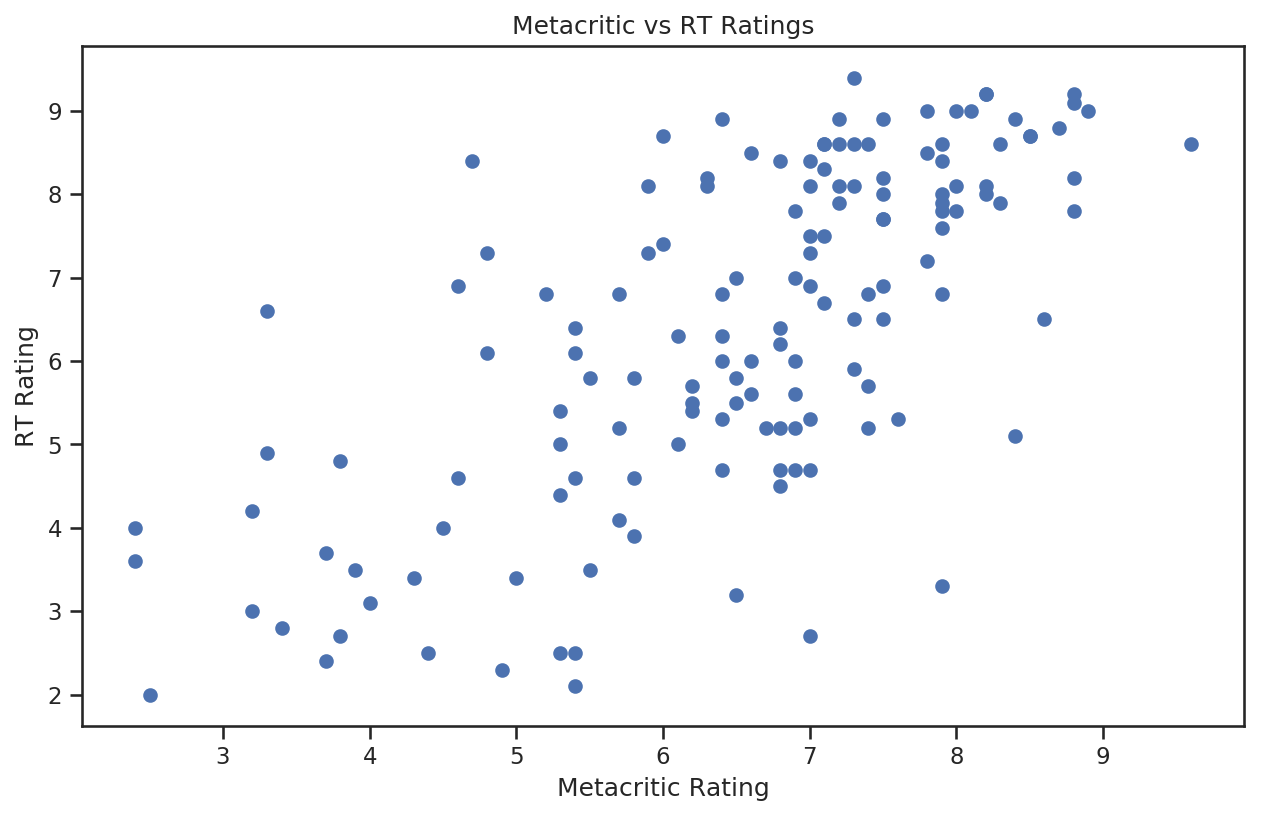

In [15]:
plt.scatter(x='Metacritic_User', y='RottenTomatoes_User_Norm', data=df)
plt.xlabel("Metacritic Rating")
plt.ylabel("RT Rating")
plt.title("Metacritic vs RT Ratings")
plt.show()

So an r-value of .68 means that we generally see that movies scoring high on one site are also scoring high on the other site. BUT, there are a some exceptions. A few movies that are rated below a five on metacritic but above a seven on Rotten Tomatoes. 

Just for fun, let's check into that. 

In [16]:
df_weird = df.query(" (Metacritic_User < 5) and (RottenTomatoes_User_Norm > 7) ")
df_weird.head()

,FILM,Fandango_Ratingvalue_Norm,Fandango_Stars_Norm,IMDB,Metacritic_Norm,Metacritic_User,RottenTomatoes_Norm,RottenTomatoes_User_Norm
3,Do You Believe? (2015),9.0,10.0,5.4,2.2,4.7,1.8,8.4
134,The Longest Ride (2015),9.0,9.0,7.2,3.3,4.8,3.1,7.3


Now there's some strange data. See if you can come up with an idea for why these films ratings would be so inconsistent. Poking around in df_full might help you out here. 

Back to the scatter plot above... It looks like there might be a stronger association between the two ratings for movies that are highly rated and less of an association for movies that are not as highly rated. There are some formal statistical tests for this type of situation, but for now let's just look at it with the tools we have. 

Let's select only the movies that are rated less than 5 by metacritic and then rerun our correlation. 

In [17]:
df_meta5_low = df.query('Metacritic_User < 5 ')
df_meta5_low['Metacritic_User'].corr(df_meta5_low['RottenTomatoes_User_Norm'])

0.37185522169931173

There does appear to be less agreement. Just to make a more apples to apple comparison, we can rerun this looking at films scoring greater than 5 on Metacritic. 

In [18]:
df_meta5_high = df.query(" Metacritic_User > 5 ")
df_meta5_high['Metacritic_User'].corr(df_meta5_high['RottenTomatoes_User_Norm'])

0.5930867366838641

Its notable that while there is a stronger assocation between ratings at the high end of the scale, using the full range of movies actually showed the strongest association between the ratings. 
***


If we call the corr() method on the entire dataframe, pandas will calculate correlations for all columns with numeric datatypes. 

In [19]:
df.corr()

,Fandango_Ratingvalue_Norm,Fandango_Stars_Norm,IMDB,Metacritic_Norm,Metacritic_User,RottenTomatoes_Norm,RottenTomatoes_User_Norm
Fandango_Ratingvalue_Norm,1.000000,0.959709,0.600354,0.177204,0.336945,0.290047,0.724329
Fandango_Stars_Norm,0.959709,1.000000,0.587295,0.181124,0.337497,0.293988,0.703683
IMDB,0.600354,0.587295,1.000000,0.727298,0.756265,0.779671,0.895297
Metacritic_Norm,0.177204,0.181124,0.727298,1.000000,0.723459,0.957360,0.690998
Metacritic_User,0.336945,0.337497,0.756265,0.723459,1.000000,0.754296,0.687132
RottenTomatoes_Norm,0.290047,0.293988,0.779671,0.957360,0.754296,1.000000,0.781440
RottenTomatoes_User_Norm,0.724329,0.703683,0.895297,0.690998,0.687132,0.781440,1.000000


The output above is often referred to as a correlation table. This correlation table allows you to see how all of our movie rating variables are correlated with one another. 
Notice there is a diagonal of 1.000 values in this output. This is the variables correlated with themselves, which always results perfect positive correlations. It is also worth noting that the left and right sides of that diagonal are redundant mirror-images of one another. Since both the diagonal values and the mirror image values provide no real information, you will sometimes see these values replaced with some other kind of statistic that provides other information. We will see an example of this in just a minute. 

Giant tables of correlation values are often challenging to interpret on thier own. One way to help is to generate a visualization of the table itself. We can do this using something called a heatmap. 
In a heat map colors are used to represent different values.

To make a heatmap we are going to import a new library called `seaborn`. You can think of `seaborn` as an extension of `matplotlib`. It does similar things in similar ways, but also makes some things easier to do. We are going to call the heatmap method from the seaborn library and we are going to pass it the correlation table above. We are also going to include the argument `cmap='Blues'` to control the type of colors that are displayed in the heatmap.

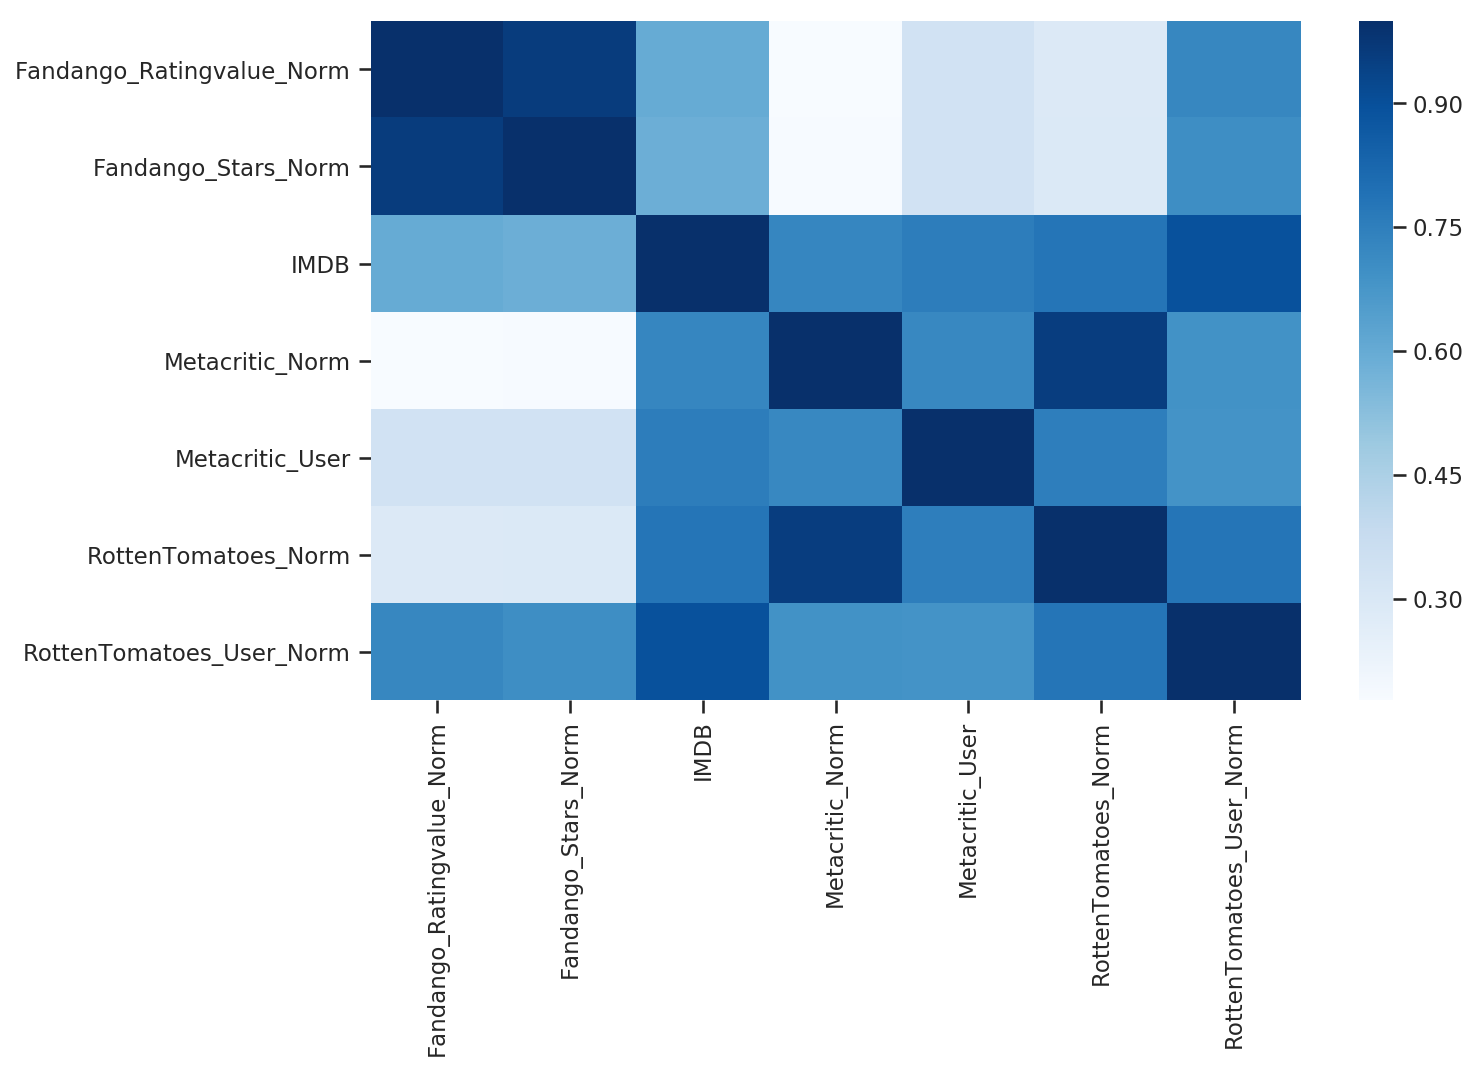

In [20]:
correlation_table = df.corr()
sns.heatmap(correlation_table, cmap="Blues")

Another method for visualizing associations across a data set is a scatter matrix. A scatter matrix is a set of scatterplots that visualize the information you would find in a correlation table.
We are going to use the seaborn `pairplot()` method and pass it our dataframe to create our scatter matrix of movie ratings.

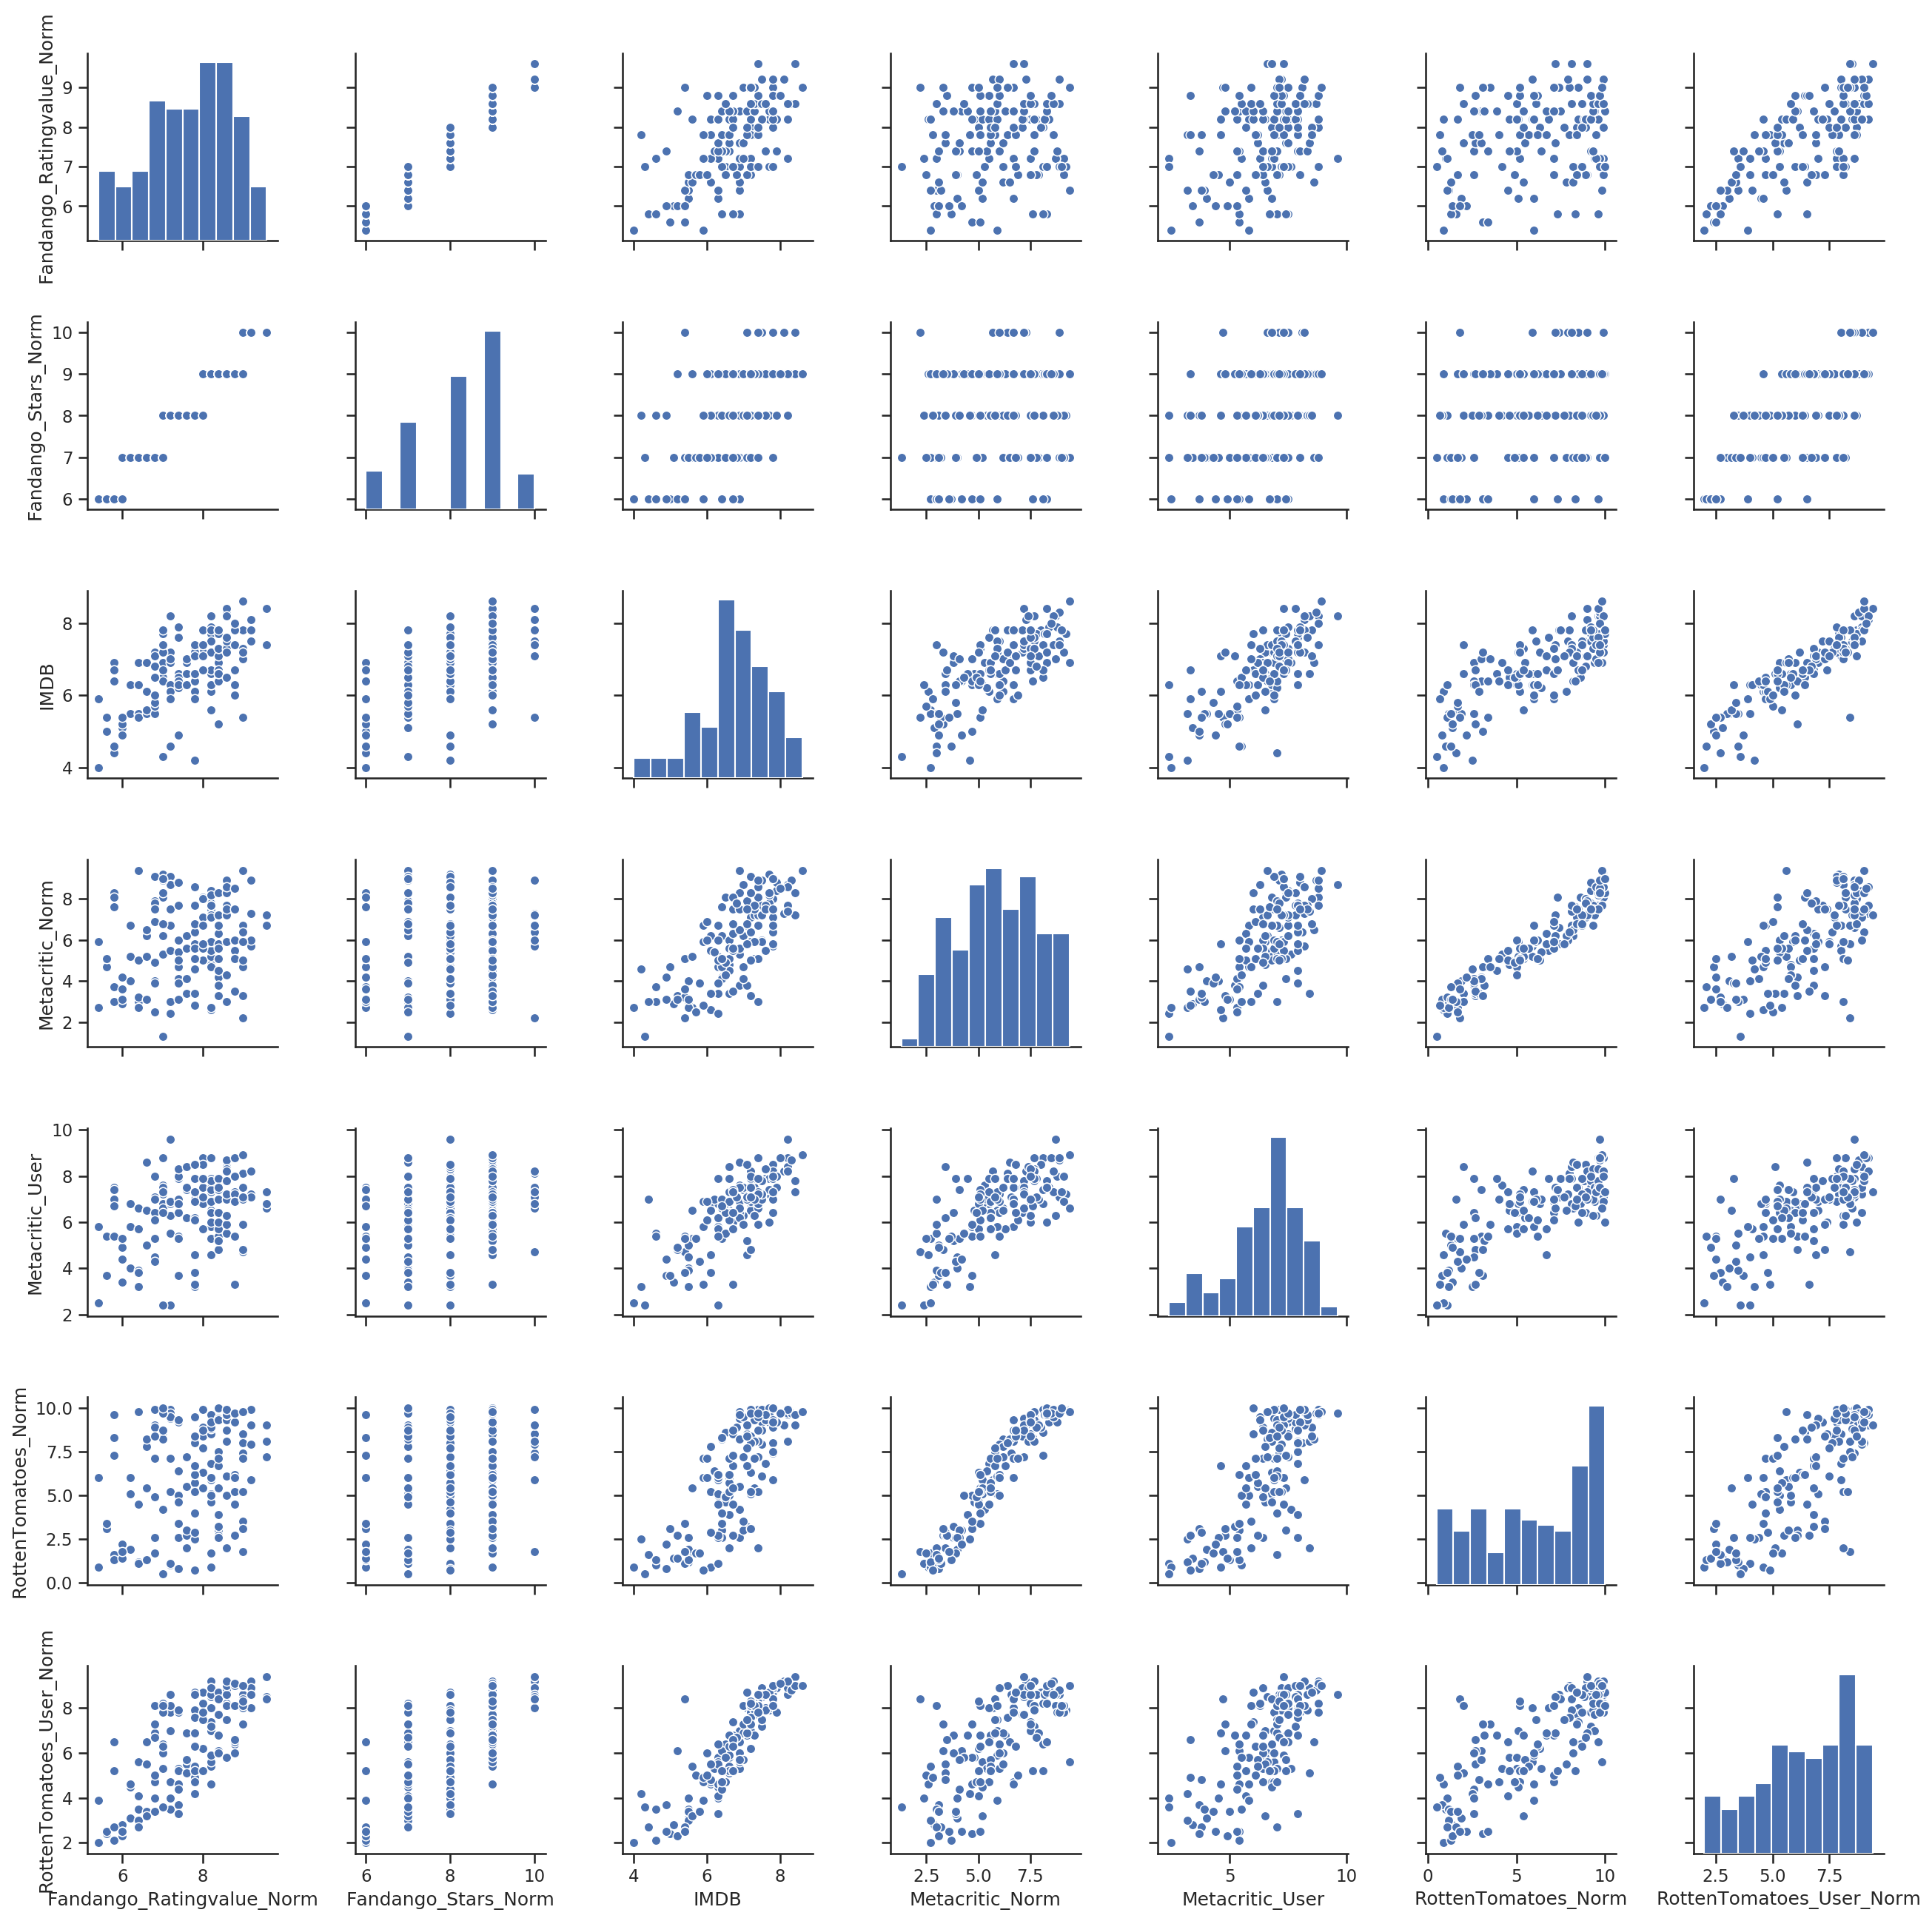

In [21]:
sns.pairplot(df) # this code creates the scatter matrix

There's a lot of information packed into the scatter matrix. First, notice the diagonals. Rather than showing us a perfect (and uninformative) correlation this scatter matrix if showing us histograms for each variable. From the histograms we wan see that 'fandango_starred_norm' only has discreet integer values. The histograms also show us that the Fandango ratings and the Rotten Tomato ratings tend to be skewed toward the positive side of the distribution. 

*** 
## Looking at Associations by Group (Category)
We will sometimes want to know if associations vary by group. For example, if our movie rating dataset had movie genre data we might be interested in finding out if the ratings from different sites more strongly associated for dramas than for comedies. Or if we had multiple years of data we might be interested to see if the associations changed by year. 

With some slight modifications to the tools we have already discussed we can start looking at associations by group. To do this we are going to use a new dataset, `'recent-grads.csv'`, which contains data about employment and salaries for recent college graduates. The data comes from [here](https://github.com/fivethirtyeight/data/tree/master/college-majors) and was used for the story [The Economic Guide to Picking Your Major](https://fivethirtyeight.com/features/the-economic-guide-to-picking-a-college-major/), published by [fivethirtyeight](https://fivethirtyeight.com/).



In [22]:
df_grad_full = pd.read_csv("recent-grads.csv") # here we read the full dataset
df_grad = df_grad_full[['Major_category', 'Major', 'ShareWomen', 'Unemployment_rate','Median']] # here we use label based indexing to create a dataset that only contains a few columns of interest
df_grad.head()

,Major_category,Major,ShareWomen,Unemployment_rate,Median
0,Engineering,PETROLEUM ENGINEERING,0.120564,0.018381,110000
1,Engineering,MINING AND MINERAL ENGINEERING,0.101852,0.117241,75000
2,Engineering,METALLURGICAL ENGINEERING,0.153037,0.024096,73000
3,Engineering,NAVAL ARCHITECTURE AND MARINE ENGINEERING,0.107313,0.050125,70000
4,Engineering,CHEMICAL ENGINEERING,0.341631,0.061098,65000


In [23]:
df_grad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 5 columns):
Major_category       173 non-null object
Major                173 non-null object
ShareWomen           172 non-null float64
Unemployment_rate    173 non-null float64
Median               173 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.8+ KB


There are 173 rows in the dataframe. Each row represents a different major. The majors are grouped into one of 16 categories. We can see the categories by calling the `unique()` method on the `'Major_category'` column.

In [24]:
df_grad['Major_category'].unique()

array(['Engineering', 'Business', 'Physical Sciences',
       'Law & Public Policy', 'Computers & Mathematics',
       'Agriculture & Natural Resources',
       'Industrial Arts & Consumer Services', 'Arts', 'Health',
       'Social Science', 'Biology & Life Science', 'Education',
       'Humanities & Liberal Arts', 'Psychology & Social Work',
       'Communications & Journalism', 'Interdisciplinary'], dtype=object)

The remaining categories represent the following: 
* ShareWomen: Percentage of graduates classified as women
* Unemployment_rate: Rate of unemployment
* Median: Median earnings of full-time, year-round workers

If we use `corr()` to look at our dataframe, one result immediately stands out. 

In [25]:
df_grad.corr()

,ShareWomen,Unemployment_rate,Median
ShareWomen,1.000000,0.073205,-0.618690
Unemployment_rate,0.073205,1.000000,-0.108833
Median,-0.618690,-0.108833,1.000000


We can use a scatter matrix to further examine this association. This time we are only going to look at associations for two different categories of majors.. First, we will use query to make a dataset that only contains categories that we are interested in. 

In [26]:
df_grad_sub = df_grad.query(' Major_category == "Engineering" or Major_category == "Psychology & Social Work" ')

Now we are going to use the seaborn `pairplot()` method again, but with one small addition. We will to pass the argument `'Major_category'` to the parameter `hue`. This parameter produces pairplots with groups. 

/share/apps/jhub/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


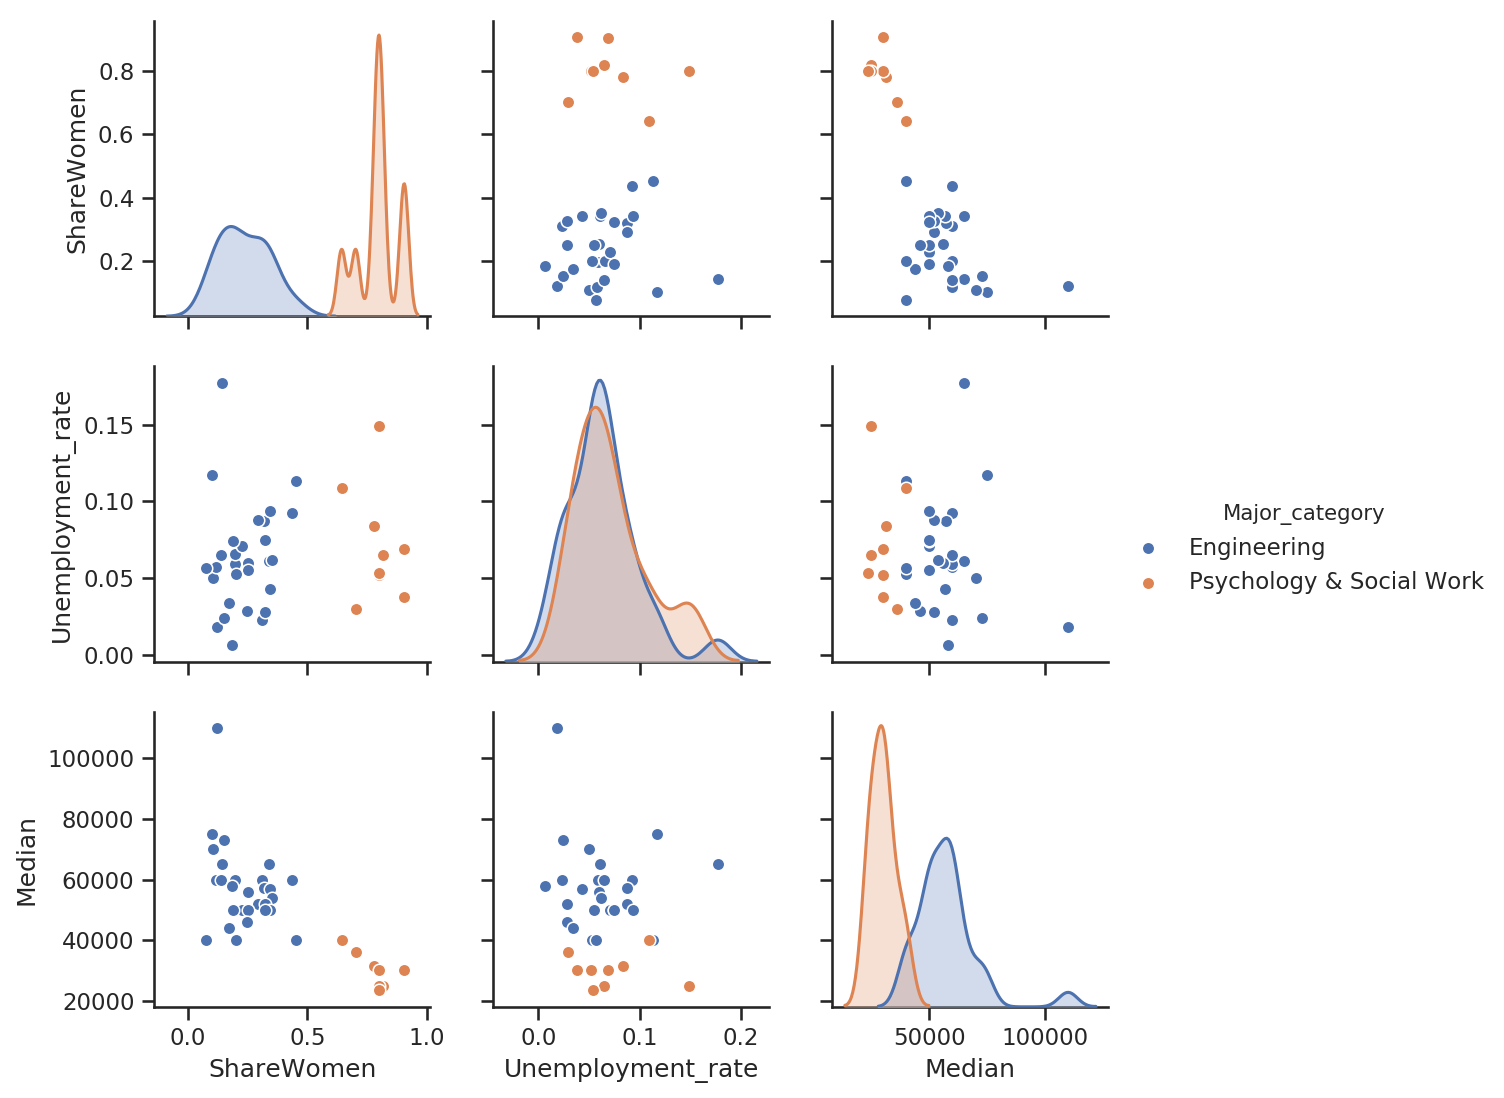

In [27]:
sns.pairplot(df_grad_sub, hue='Major_category')

The diagonals are again providing information about the frequency of specific values, but in this case the frequencies are represented in different colors for the different categories of majors. The same is done for the scatterplots. 